In [1]:
import os
import re
import pandas as pd
import shutil
import subprocess

import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib notebook

In [12]:
home = os.path.join(os.path.split(os.getcwd())[:-1])[0]

In [40]:
def remove_file_whitespace(fpath):
    # Removes whitespace from output file
    # No return value; replaces original .out file
    fname = os.path.basename(fpath)

    with open("tmp.txt", "w") as tmp:
        with open(fpath, "r") as f:
            for line in f:
                subbed = re.sub("\s*", "", line.strip())
                tmp.write("%s\n" % subbed)
    shutil.move("tmp.txt", fpath)
    
def convert_to_usec(fpath):
    # Converts the file at fpath to us by calling an octave program
    # No return value; will write a file fpath.dat
    remove_file_whitespace(fpath)
    
    subprocess.call(["octave", 
                    os.path.join(home, "convert_raw_to_usec.oct"),
                   os.path.basename(fpath).split(".")[0],
                os.path.split(fpath)[:-1][0]])
    
def load_datfiles(dirname, fname_filter="*"):
    # Loads all the files in dirname/, filtered by fname_filter
    # Returns a list of (filename, df) tuples
    files = os.listdir(dirname)
    files = [fname for fname in files 
             if fname_filter in fname and ".out" in fname]
    
    dfs = []
    
    for fname in files: 
        stem = os.path.join(dirname, fname.split(".")[0])
        print "Working on %s..." % fname
        if not os.path.exists(stem + ".dat"):
            print "Converting to usec..."
            convert_to_usec(stem + ".out")
        dfs.append(load_datfile(stem + ".dat"))
            
    return dfs

def load_datfile(fpath):
    # Returns a (filename, df) tuple where df has latency computed
    df = pd.read_csv(fpath, 
                     index_col=False, 
                     names=["send_secs", "recv_secs"])
    df["latency(us)"] = df["recv_secs"] - df["send_secs"]
    return (os.path.basename(fpath), df)

def plot_multiple_cdfs(df_tuple_list):
    # Takes a list of (fname, df) tuples and prints a CDF of RTTs
    # Returns a new df where each column is an experiment and values are computed RTTs
    # for that experiment
    dfs = [pd.Series(x[1]["latency(us)"], name=x[0]) for x in df_tuple_list]
    latencies = pd.concat(dfs, axis=1)
    ax = latencies.plot(kind="hist", 
                   cumulative=True, 
                   normed=1, 
                   bins=1000, 
                   histtype="step",
                   linewidth="2.0",
                  title="RTT")
    ax.set_xlabel("RTT (us)")
    return latencies

In [45]:
expdir = "/home/theano/mountpoint/tsch/mininetpipe/results/tcp_vardelay"
dfs = load_datfiles(expdir, "TCP")

Working on TCP-1506457551-r1000-s100.out...
Working on TCP-1506458247-r1000-s140.out...
Working on TCP-1506458296-r1000-s740.out...
Working on TCP-1506457538-r1000-s10.out...
Working on TCP-1506458274-r1000-s260.out...
Working on TCP-1506457524-r1000-s0.out...
Working on TCP-1506457571-r1000-s10000.out...
Working on TCP-1506457561-r1000-s1000.out...
Working on TCP-1506458264-r1000-s180.out...
Working on TCP-1506458286-r1000-s420.out...
Working on TCP-1506458236-r1000-s120.out...


In [72]:
# Sort by recv-send delay
dfs.sort(key=lambda x: int(re.sub("[^\d]+", "", x[0].split("-")[-1])))
print [x[0] for x in dfs]

['TCP-1506457524-r1000-s0.dat', 'TCP-1506457538-r1000-s10.dat', 'TCP-1506457551-r1000-s100.dat', 'TCP-1506458236-r1000-s120.dat', 'TCP-1506458247-r1000-s140.dat', 'TCP-1506458264-r1000-s180.dat', 'TCP-1506458274-r1000-s260.dat', 'TCP-1506458286-r1000-s420.dat', 'TCP-1506458296-r1000-s740.dat', 'TCP-1506457561-r1000-s1000.dat', 'TCP-1506457571-r1000-s10000.dat']


<IPython.core.display.Javascript object>


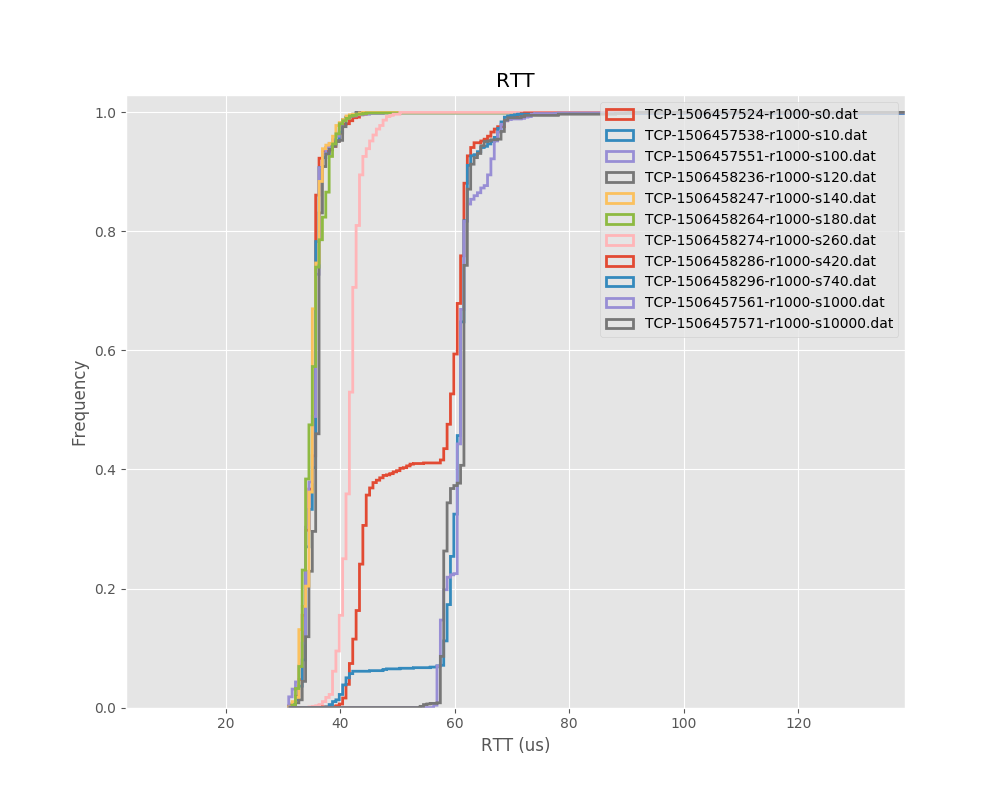

In [73]:
latencies = plot_multiple_cdfs(dfs)

Working on UDP-1506459227-r1000-s120.out...
Converting to usec...
Working on UDP-1506459252-r1000-s180.out...
Converting to usec...
Working on UDP-1506459297-r1000-s1000.out...
Converting to usec...
Working on UDP-1506459287-r1000-s740.out...
Converting to usec...
Working on UDP-1506459274-r1000-s420.out...
Converting to usec...
Working on UDP-1506459357-r1000-s0.out...
Converting to usec...
Working on UDP-1506459243-r1000-s140.out...
Converting to usec...
Working on UDP-1506459265-r1000-s260.out...
Converting to usec...
Working on UDP-1506459347-r1000-s10.out...
Converting to usec...
Working on UDP-1506459315-r1000-s10000.out...
Converting to usec...
Working on UDP-1506459339-r1000-s100.out...
Converting to usec...


<IPython.core.display.Javascript object>


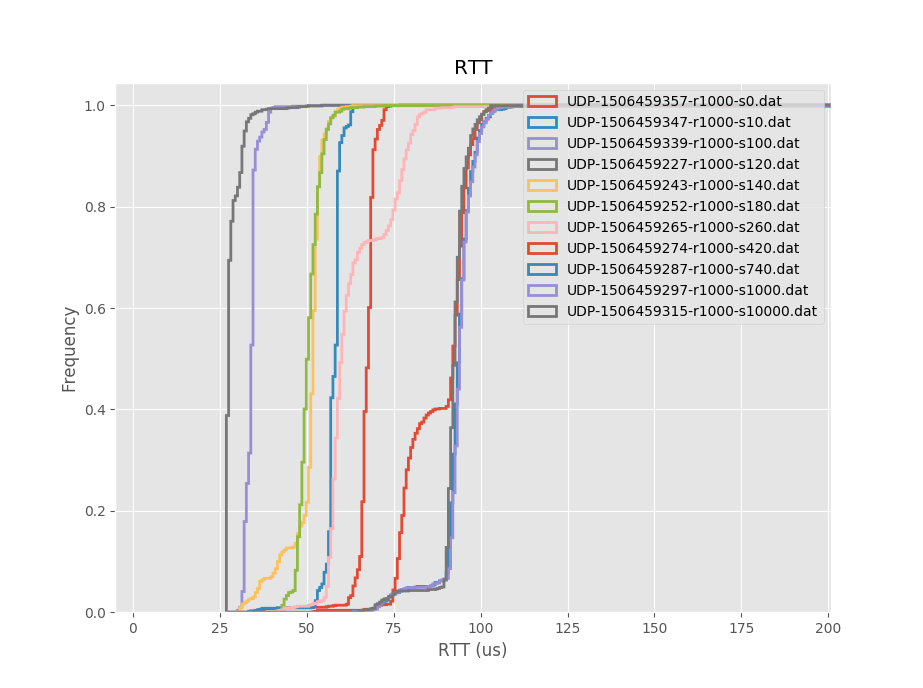

In [75]:
udp_expdir = "/home/theano/mountpoint/tsch/mininetpipe/results/udp_vardelay"
udp_dfs = load_datfiles(udp_expdir, "UDP")

# Sort by recv-send delay
udp_dfs.sort(key=lambda x: int(re.sub("[^\d]+", "", x[0].split("-")[-1])))

udp_latencies = plot_multiple_cdfs(udp_dfs)